In [57]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
def load_mel_spectrograms_from_h5(file_path):
    try:
        with h5py.File(file_path, "r") as h5_file:
            print(h5_file.keys())
            X = h5_file['X']
            y = h5_file['y']
            return np.array(X), np.array(y)
    except:
        print("Lỗi trong quá trình load dữ liệu từ file!")

In [3]:
file_path = r"D:\Tài liệu học đại học\ML_Project\processed_data.h5"

In [4]:
X, y = load_mel_spectrograms_from_h5(file_path)

<KeysViewHDF5 ['X', 'y']>


In [5]:
print(X.shape, y.shape)

(7000, 16640) (7000,)


In [52]:
X[:5]

array([[8.74202028e-02, 9.50330123e-02, 1.35096654e-01, ...,
        1.12799404e-04, 1.13682188e-04, 2.93059601e-03],
       [1.61605000e-01, 1.50879594e-02, 1.15182502e-02, ...,
        2.77950399e-04, 5.13567415e-04, 4.41766484e-03],
       [6.10321797e-02, 2.09733978e-01, 1.92124516e-01, ...,
        1.21414276e-04, 9.19210215e-05, 1.27230911e-03],
       [1.09099060e-01, 1.44950628e-01, 4.67027724e-02, ...,
        2.08840051e-04, 1.78731207e-04, 3.14676277e-02],
       [7.21759051e-02, 2.81110238e-02, 5.58887348e-02, ...,
        1.32149551e-03, 1.38527004e-03, 1.29352724e-02]],
      shape=(5, 16640), dtype=float32)

In [53]:
X_reshape = X.reshape((7000, 128, 130))

In [6]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [56]:
X_reshape.shape

(7000, 128, 130)

In [7]:
def process_data_label(y, new_label):
    y_new_label = [1 if label == new_label else 0 for label in y]
    return y_new_label

In [8]:
def reshape_dims_data(X, y):
    X_new = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    y_new = np.array([[label] * X.shape[1] for label in y]).reshape(-1)
    return X_new, y_new

In [58]:
X_new, y_new = reshape_dims_data(X_reshape, y)
print(X_new.shape, y_new.shape)

(896000, 130) (896000,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new,
                                                    test_size=0.2, random_state=42)

In [116]:
pca = IncrementalPCA()
pca.fit(X)

IncrementalPCA()

In [108]:
def graphs_phuong_sai(phuong_sai):
    plt.plot(range(1, len(phuong_sai) + 1), phuong_sai)
    plt.xlabel("Số thành phần chính")
    plt.ylabel("Tỷ lệ phương sai giải thích")
    plt.title("Tỷ lệ phương sai PCA")
    plt.show()

In [109]:
pca.explained_variance_ratio_

array([1.17197308e-01, 5.46164388e-02, 3.05700721e-02, ...,
       2.29215570e-20, 1.82871422e-20, 3.13278522e-21], shape=(7000,))

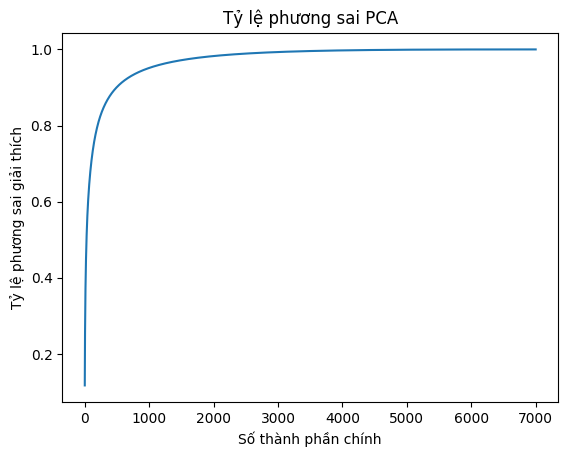

In [111]:
#Ty le phuong sai giai thich
phuong_sai = np.cumsum(pca.explained_variance_ratio_)
graphs_phuong_sai(phuong_sai=phuong_sai)

In [117]:
#Lựa chọn số thành phần sao cho ty le phương sai giai thich >= 0.95
n_components = np.argmax(phuong_sai >= 0.95) + 1
print(n_components)

978


In [9]:
pca_transform = PCA(n_components=978)
X_old = pca_transform.fit_transform(X)

In [12]:
np.save("X_old.npy", X_old)

In [16]:
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y,
                                                    test_size=0.2, random_state=42)

## Label One vs All

In [ ]:
print(X_train_old.shape, X_test_old.shape, y_train_old.shape, y_test_old.shape)

(5600, 978) (1400, 978) (5600,) (1400,)


In [20]:
np.unique(y_train_old)

array([0, 1, 2, 3, 4, 5, 6])

In [22]:
model = svm.SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr")
model.fit(X_train_old, y_train_old)

SVC()

In [27]:
y_pred_old = model.predict(X_test_old)

In [28]:
accuracy = accuracy_score(y_test_old, y_pred_old)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8664


In [33]:
labels = [i for i in range(len(np.unique(y_pred_old)))]
def graphics_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Nhãn dự đoán")
    plt.ylabel("Nhãn thực tế")
    plt.title('Confusion Matrix Heatmap')
    plt.show()

In [35]:
cm = confusion_matrix(y_test_old, y_pred_old)

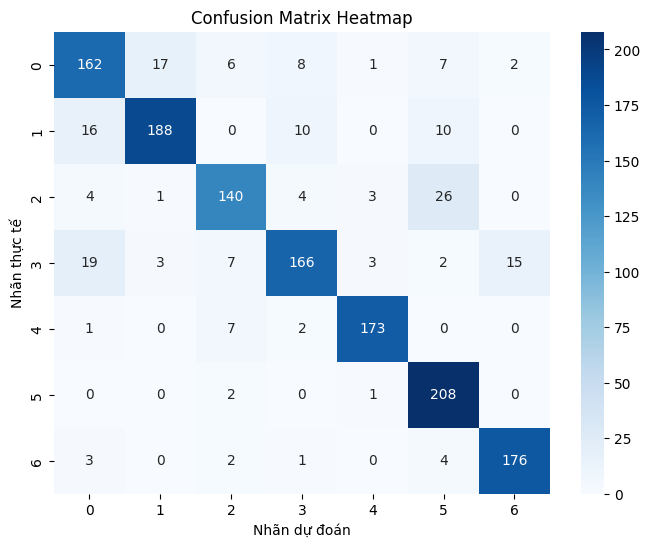

In [36]:
graphics_confusion_matrix(cm)

In [48]:
svc = svm.SVC()
parameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
              'C': [0.1, 1, 10, 100],
              'gamma': ['auto', 'scale'],
              'degree': [3, 4]}

In [49]:
grid_search = GridSearchCV(svc, parameters, cv=5)
grid_search.fit(X_train_old, y_train_old)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [3, 4],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [50]:
print(grid_search.best_params_)

{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [51]:
best_model = grid_search.best_estimator_

In [52]:
y_pred_old_grid = best_model.predict(X_test_old)

In [55]:
print(accuracy_score(y_test_old, y_pred_old_grid))

0.8807142857142857


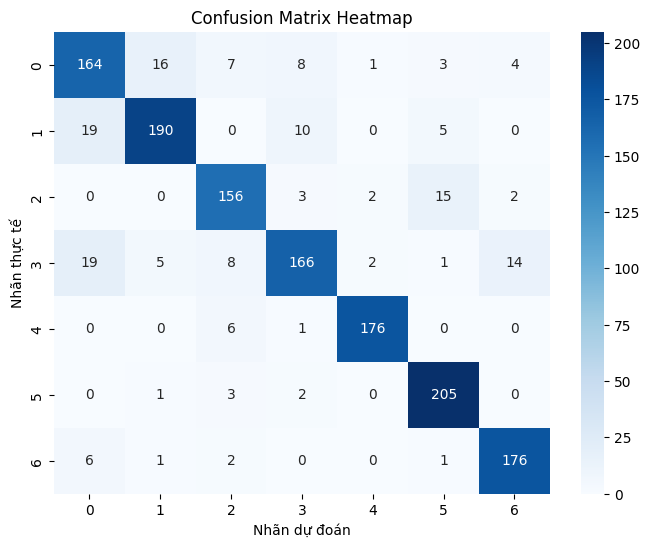

In [53]:
cm_grid = confusion_matrix(y_test_old, y_pred_old_grid)
graphics_confusion_matrix(cm=cm_grid)

In [58]:
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')

['best_model.pkl']